In [1]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
from nltk.corpus import stopwords

In [4]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [5]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [6]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='Sil_struktur.csv.bz2'

In [7]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/skuratov/,NaN,Россия,Cледствие по делу Скуратова продлено еще на 4 ...,Генеральная прокуратура продлила еще на 4 меся...,Силовые структуры,генеральный прокуратура продлить 4 месяцасрок ...
1,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/bank_skandal/,NaN,Россия,Зять Ельцина вызван на допрос,Зять президента Ельцина Леонид Дьяченко вызван...,Силовые структуры,зять ельцин леонид дьяченко вызвать допрос бол...
2,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/chechnya/,NaN,Россия,Чечня полностью изолирована,По заявлению командующего объединенной федерал...,Силовые структуры,заявление командующий объединить федеральный г...
3,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/samara_vaz/,NaN,Россия,В Самарской области убит директор автомобильно...,"Директор фирмы ""Эверест"" и его жена погибли в ...",Силовые структуры,директор фирма эверест жена погибнуть сильный ...
4,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/baturina/,NaN,Россия,Жена Лужкова решила обжаловать в суде действия...,Жена московского мэра Елена Батурина обратилас...,Силовые структуры,жена московский мэр елена батурин обратиться ж...


In [8]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [9]:
data['new_text']=data.text_lema.apply(pre_proc)

In [10]:
data.drop(data[data.text=='text'].index,inplace=True)

In [11]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/skuratov/,NaN,Россия,Cледствие по делу Скуратова продлено еще на 4 ...,Генеральная прокуратура продлила еще на 4 меся...,Силовые структуры,генеральный прокуратура продлить 4 месяцасрок ...,"[генеральный, прокуратура, продлить, 4, месяца..."
1,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/bank_skandal/,NaN,Россия,Зять Ельцина вызван на допрос,Зять президента Ельцина Леонид Дьяченко вызван...,Силовые структуры,зять ельцин леонид дьяченко вызвать допрос бол...,"[зять, ельцин, леонид, дьяченко, вызвать, допр..."
2,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/chechnya/,NaN,Россия,Чечня полностью изолирована,По заявлению командующего объединенной федерал...,Силовые структуры,заявление командующий объединить федеральный г...,"[заявление, командующий, объединить, федеральн..."
3,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/samara_vaz/,NaN,Россия,В Самарской области убит директор автомобильно...,"Директор фирмы ""Эверест"" и его жена погибли в ...",Силовые структуры,директор фирма эверест жена погибнуть сильный ...,"[директор, фирма, эверест, жена, погибнуть, си..."
4,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/baturina/,NaN,Россия,Жена Лужкова решила обжаловать в суде действия...,Жена московского мэра Елена Батурина обратилас...,Силовые структуры,жена московский мэр елена батурин обратиться ж...,"[жена, московский, мэр, елена, батурин, обрати..."


### Модель

In [12]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 5.07 s, sys: 19.8 ms, total: 5.09 s
Wall time: 5.1 s


In [13]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 3.76 s, sys: 128 ms, total: 3.89 s
Wall time: 3.89 s


In [14]:
num_topic=20

In [15]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=num_topic, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.109726966472167
Coherence Score: 0.5310454774138107
CPU times: user 20min 44s, sys: 1.46 s, total: 20min 46s
Wall time: 19min 27s


### Топ-топики в текстах

In [16]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 3min 36s, sys: 411 ms, total: 3min 37s
Wall time: 3min 39s


In [17]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.3153,"следственный, уголовный, заместитель, прокуратура","[генеральный, прокуратура, продлить, 4, месяца..."
1,1,17.0,0.6130,"россия, российский, источник, издание","[зять, ельцин, леонид, дьяченко, вызвать, допр..."
2,2,4.0,0.4645,"боевик, район, чечня, республика, дагестан","[заявление, командующий, объединить, федеральн..."
3,3,7.0,0.2379,"автомобиль, орган, источник, правоохранительный","[директор, фирма, эверест, жена, погибнуть, си..."
4,4,6.0,0.3669,"россия, москва","[жена, московский, мэр, елена, батурин, обрати..."
5,5,7.0,0.4384,автомобиль,"[159, тысяча, рубль, дневный, выручка, похитит..."
6,6,17.0,0.5272,"россия, мвд","[конец, этап, операция, контроль, приезжий, пр..."
7,7,1.0,0.7227,"миллион, уголовный, возбудить, управление","[сотрудник, управление, борьба, экономический,..."
8,8,10.0,0.2287,"следственный, управление, начальник, уголовный","[шесть, привлечь, уголовный, ответственность, ..."
9,9,17.0,0.3673,"россия, российский","[уголовно-исполнительный, система, начинаться,..."


### Статистика по топикам

In [18]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 49.4 ms, sys: 0 ns, total: 49.4 ms
Wall time: 49.4 ms


### График по времени

In [19]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/Sil_struktur_update.csv.bz2',compression='bz2', index=False)

CPU times: user 1min 46s, sys: 351 ms, total: 1min 46s
Wall time: 1min 47s


In [20]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

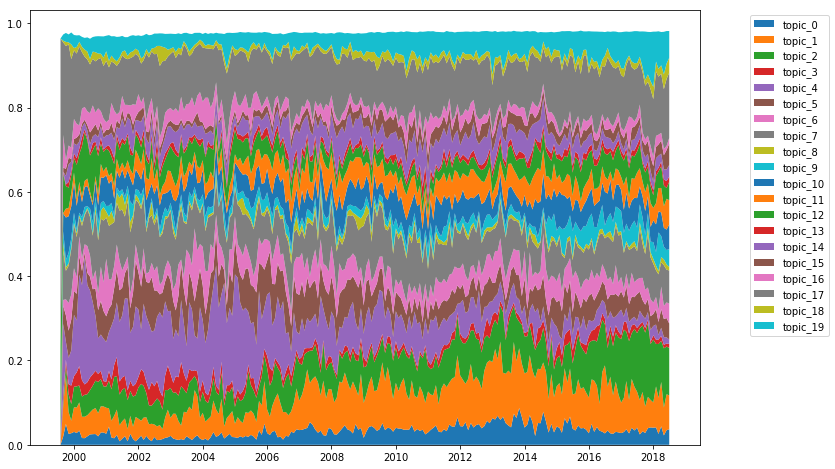

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [22]:
ldamodel1.print_topics()

[(0,
  '0.047*"рубль" + 0.029*"миллион" + 0.018*"банка" + 0.017*"средство" + 0.016*"миллиард" + 0.014*"счёт" + 0.014*"деньга" + 0.013*"сумма" + 0.011*"хищение" + 0.009*"мошенничество"'),
 (1,
  '0.020*"рубль" + 0.018*"миллион" + 0.017*"уголовный" + 0.015*"взятка" + 0.014*"следствие" + 0.012*"задержать" + 0.011*"получение" + 0.010*"возбудить" + 0.010*"управление" + 0.010*"размер"'),
 (2,
  '0.021*"статья" + 0.020*"уголовный" + 0.020*"задержать" + 0.016*"мужчина" + 0.015*"возбудить" + 0.015*"ук" + 0.015*"рф" + 0.014*"область" + 0.013*"подозревать" + 0.011*"следственный"'),
 (3,
  '0.054*"военный" + 0.020*"минобороны" + 0.018*"военнослужащий" + 0.016*"войско" + 0.013*"часть" + 0.012*"оборона" + 0.012*"васильев" + 0.010*"служба" + 0.009*"офицер" + 0.009*"полковник"'),
 (4,
  '0.031*"боевик" + 0.017*"район" + 0.015*"чечня" + 0.015*"республика" + 0.015*"дагестан" + 0.011*"спецоперация" + 0.009*"уничтожить" + 0.009*"орган" + 0.009*"ингушетия" + 0.009*"ход"'),
 (5,
  '0.027*"адвокат" + 0.018*"

### Топ слова.

In [23]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [24]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [25]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

задержать - 21905 times.
уголовный - 20054 times.
россия - 19397 times.
сотрудник - 19318 times.
следствие - 19053 times.
убийство - 17133 times.
москва - 16817 times.
рф - 16676 times.
рубль - 15361 times.
мвд - 14635 times.
орган - 12756 times.
статья - 12686 times.
данные - 12632 times.
управление - 12570 times.
новость - 12046 times.
следственный - 11888 times.
бывший - 11820 times.
преступление - 11699 times.
миллион - 11622 times.
возбудить - 10927 times.
подозревать - 10160 times.
правоохранительный - 10133 times.
район - 9550 times.
прокуратура - 9461 times.
область - 9338 times.
интерфакс - 9289 times.
боевик - 9260 times.
адвокат - 8993 times.
обвинение - 8913 times.
обвинять - 8824 times.
источник - 8475 times.
информация - 8315 times.
дом - 8226 times.
тысяча - 8214 times.
агентство - 7967 times.
ход - 7934 times.
версия - 7802 times.
часть - 7691 times.
комитет - 7614 times.
московский - 7590 times.
ук - 7541 times.
фсб - 7425 times.
следователь - 7372 times.
место - 7207 